In [101]:
import random

import torch
from torchvision import transforms
from PIL import Image
import folium

from nsvd import NSVD, plot_img
from norwai_models import Haversine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [102]:
tf = transforms.Compose([
  transforms.RandomResizedCrop((224, 224), (0.7, 1)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])
tf1 = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

norm_tf = transforms.Compose([
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Used for custom image
#img = Image.open('./data/test_images/my_image.png').convert('RGB')
#img = tf(img)

test = NSVD('./data', False, 'coords', False, transforms=tf)
test1 = NSVD('./data', False, 'coords', False, transforms=tf1)

tensor([69.2581, 15.9655], device='cuda:0')


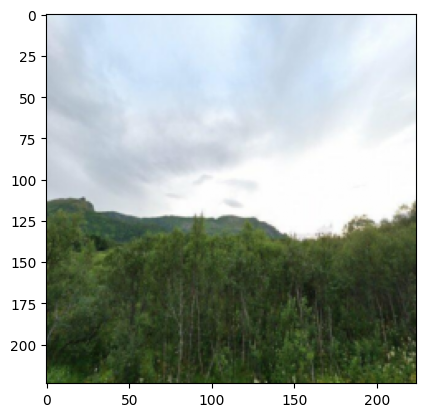

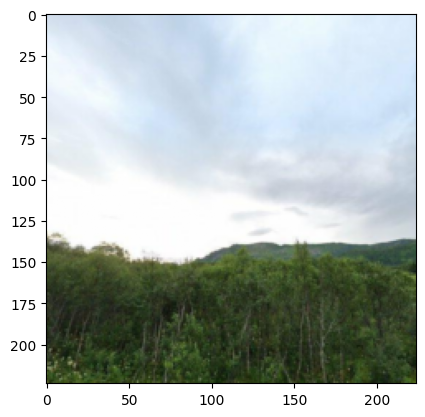

In [103]:
# comment these out if using custom image
idx = random.randint(0, len(test)-1)
img, coords, _ = test[idx]
img1, coords1, _ = test[idx]

img, coords = img.to(device), torch.tensor(coords).to(device).float()
print(coords)

plot_img(img.cpu())
plot_img(img1)
img = norm_tf(img)

In [104]:
model = torch.load('./data/trained_models/distance/effnet.model')
model.to(device)
model.eval()


with torch.no_grad():
  guess = model(img.unsqueeze(0)).flatten()
  print(guess)

print(coords)
print(guess)


tensor([68.9856, 16.6842], device='cuda:0')
tensor([69.2581, 15.9655], device='cuda:0')
tensor([68.9856, 16.6842], device='cuda:0')


In [105]:
loss_fn = Haversine()
def get_distance(a,b):
  a = a.unsqueeze(0)
  b = b.unsqueeze(0)
  print(a.shape, b.shape)
  print("distance: {}".format(loss_fn(a[:, 0], a[:, 1], b[:, 0], b[:, 1])))

get_distance(guess, coords)

torch.Size([1, 2]) torch.Size([1, 2])
distance: 41.581539154052734


In [106]:
m = folium.Map((64.9701, 13.509217), zoom_start=4)
folium.CircleMarker(location=(coords[0], coords[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
folium.CircleMarker(location=(guess[0], guess[1]), tooltip='guessed', radius=1, color='#d40834', fill_color='#d40834').add_to(m)
folium.PolyLine([(coords[0], coords[1]),(guess[0], guess[1])], color='red').add_to(m)

m
